Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

##**Importing Skin Cancer Data**

##**Importing all the important libraries**

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
#commenting below so that it doesn't run everytime. uncomment on need basis
#!unzip /content/drive/MyDrive/CNN_assignment.zip -d /content/drive/MyDrive/CNN_assignment

In [3]:
# Defining the path for train and test images
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')
data_dir_train = pathlib.Path('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

## Create a dataset
Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## train dataset here
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,label_mode='categorical', batch_size=32,image_size=(img_height,img_width),seed=123,subset='training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
##  validation dataset here
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,label_mode='categorical', batch_size=32,image_size=(img_height,img_width),seed=123,subset='validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data
### create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
import matplotlib.pyplot as plt

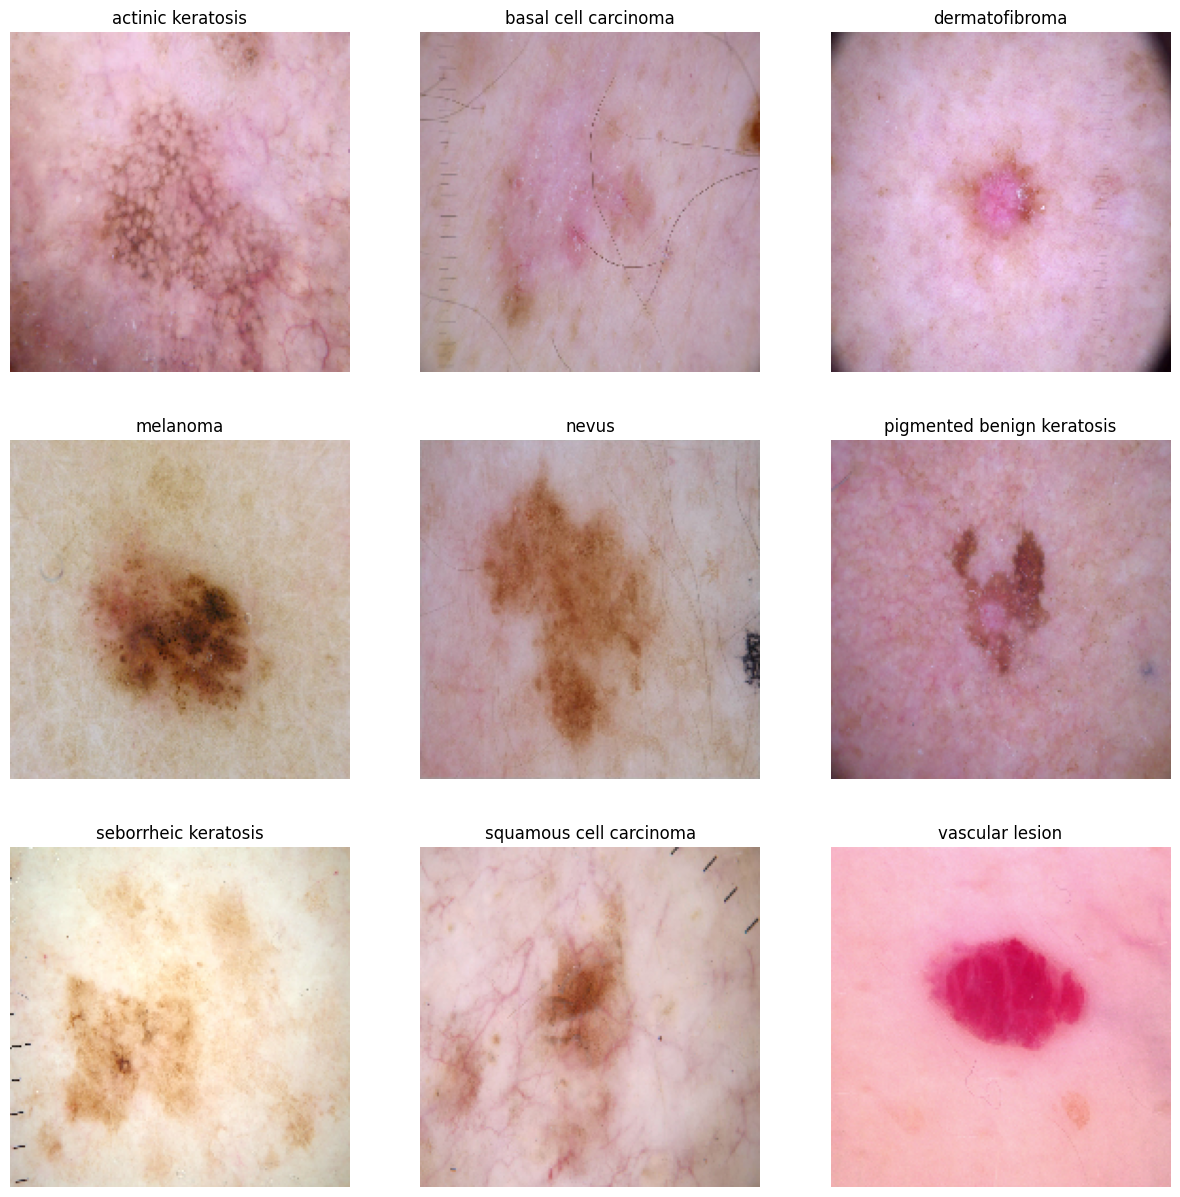

In [ ]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0

for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[np.random.randint(0,len(path_list))],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

plt.show()

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model
### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer


#First Convulation layer
model.add(layers.Conv2D(32,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128))
model.add(layers.Activation('relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 activation (Activation)     (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 87, 87, 64)        0         
                                                        

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 571s 2s/step - loss: 2.1184 - accuracy: 0.2009 - val_loss: 2.0066 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 52ms/step - loss: 1.9184 - accuracy: 0.2941 - val_loss: 1.6858 - val_accuracy: 0.3848
Epoch 3/20
56/56 [==============================] - 3s 52ms/step - loss: 1.6731 - accuracy: 0.4129 - val_loss: 1.6110 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 1.5651 - accuracy: 0.4420 - val_loss: 1.4977 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.5180 - accuracy: 0.4704 - val_loss: 1.5519 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4253 - accuracy: 0.5089 - val_loss: 1.4307 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 3s 51ms/step - loss: 1.4034 - accuracy: 0.5128 - val_loss: 1.3886 - val_accuracy: 0.5302
Epoch 8/20
56

### Visualizing training results

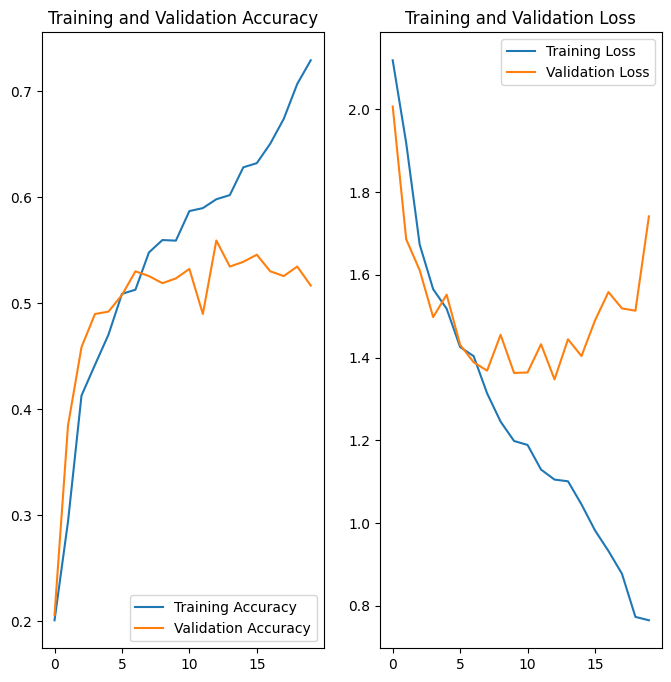

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Analysis
### **There is clearly a huge difference between training and validation accuracy. This indicates that the model is clearly an overfit model. Also the Validation loss is not recovering even with the incresing number of epochs but the training loss is decreasing. This is another indication of overfitting.**

In [14]:
# Importing necessary functions
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
		rotation_range = 40,
		shear_range = 0.2,
		zoom_range = 0.2,
		horizontal_flip = True,
		brightness_range = (0.5, 1.5))

# Loading a sample image
sample_dir = str(data_dir_train)+'/'+class_names[0]
img = load_img(os.path.join(sample_dir,os.listdir(str(data_dir_train)+'/'+class_names[0])[5]))
# Converting the input sample image to an array
x = img_to_array(img)
# Reshaping the input image
x = x.reshape((1, ) + x.shape)

# Generating and saving 5 augmented samples
# using the above defined parameters.
i = 0
for batch in datagen.flow(x, batch_size = 1,
						save_to_dir =data_dir_train+'/',
						save_prefix ='aug', save_format ='jpeg'):
	i += 1
	if i > 5:
		break


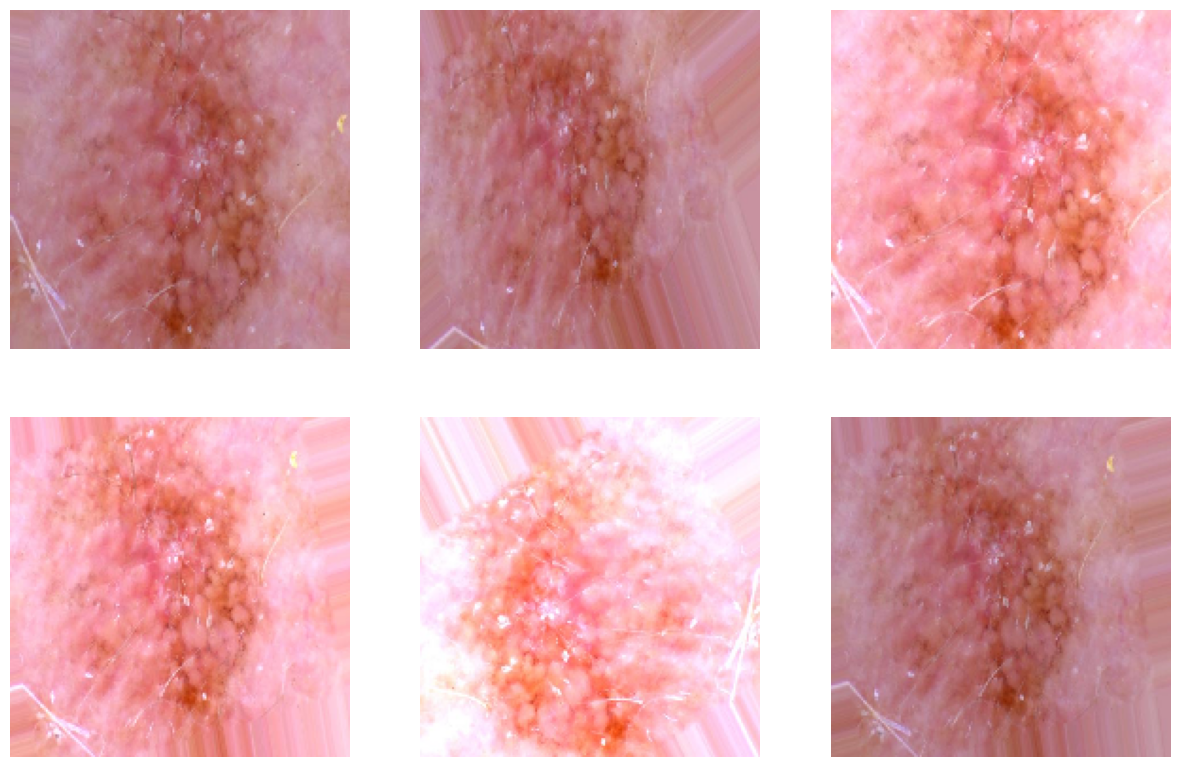

In [21]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, 'aug*.jpeg'))]

plt.figure(figsize=(15,15))
index = 0

for path in path_list:
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path,target_size=(180,180)))
    #plt.title(c)
    plt.axis("off")

plt.show()

### **Visualize distribution of classes in the training dataset.**

In [25]:
def image_class_distrib_cnt(dir):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(dir).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_dir = [name for name in os.listdir(dir)
                    if os.path.isdir(os.path.join(dir, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_dir,count)),columns =['Class', 'No. of Image'])

df = image_class_distrib_cnt(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [1]:
!pip install Augmentor

In [12]:
path_to_training_dataset="/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B65DC19A380>: 100%|██████████| 500/500 [00:20<00:00, 24.39 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B65DC1EF760>: 100%|██████████| 500/500 [00:19<00:00, 26.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B65DDABA470>: 100%|██████████| 500/500 [00:18<00:00, 27.38 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B65DC204CA0>: 100%|██████████| 500/500 [01:31<00:00,  5.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7B65DC227490>: 100%|██████████| 500/500 [01:22<00:00,  6.05 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B666EB96680>: 100%|██████████| 500/500 [00:18<00:00, 27.53 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B65DC1EEB00>: 100%|██████████| 500/500 [00:43<00:00, 11.42 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B65DC2264D0>: 100%|██████████| 500/500 [00:18<00:00, 26.58 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B666EB97220>: 100%|██████████| 500/500 [00:20<00:00, 24.29 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [17]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [28]:
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [29]:
dataframe_dict = dict(zip(path_list, lesion_list))
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2])

In [31]:
new_df['Label'].value_counts()

Label
Train                         2239
actinic keratosis              500
basal cell carcinoma           500
dermatofibroma                 500
melanoma                       500
nevus                          500
pigmented benign keratosis     500
seborrheic keratosis           500
squamous cell carcinoma        500
vascular lesion                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **Train the model on the data created using Augmentor**

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [11]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [12]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 1721s 2s/step - loss: 1.8494 - accuracy: 0.3092 - val_loss: 1.5117 - val_accuracy: 0.3972
Epoch 2/30
169/169 [==============================] - 9s 55ms/step - loss: 1.5199 - accuracy: 0.4169 - val_loss: 1.3353 - val_accuracy: 0.5019
Epoch 3/30
169/169 [==============================] - 9s 56ms/step - loss: 1.3689 - accuracy: 0.4846 - val_loss: 1.2679 - val_accuracy: 0.5234
Epoch 4/30
169/169 [==============================] - 9s 55ms/step - loss: 1.2702 - accuracy: 0.5187 - val_loss: 1.1909 - val_accuracy: 0.5590
Epoch 5/30
169/169 [==============================] - 9s 55ms/step - loss: 1.1997 - accuracy: 0.5464 - val_loss: 1.0651 - val_accuracy: 0.6169
Epoch 6/30
169/169 [==============================] - 9s 56ms/step - loss: 1.0396 - accuracy: 0.6100 - val_loss: 1.0380 - val_accuracy: 0.6273
Epoch 7/30
169/169 [==============================] - 9s 55ms/step - loss: 0.9107 - accuracy: 0.6606 - val_loss: 0.9786 - val_accuracy: 0.642

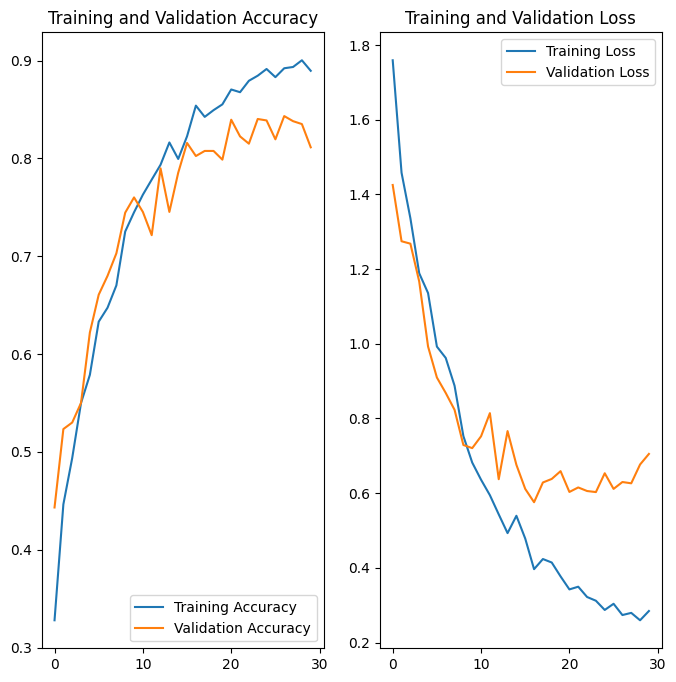

In [38]:
# Plot the training curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Now the training accuracy and validation accuracy is close and thus we can infer that the model is a fairly good fit. We could probably use Batch Normalization with dropouts at each layer to get a better fit**

### Model Prediction

['/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion/ISIC_0024402.jpg', '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion/ISIC_0024375.jpg', '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion/ISIC_0024370.jpg']
1/1 [==============================] - 0s 19ms/step
Actual Class vascular lesion
Predictive Class vascular lesion


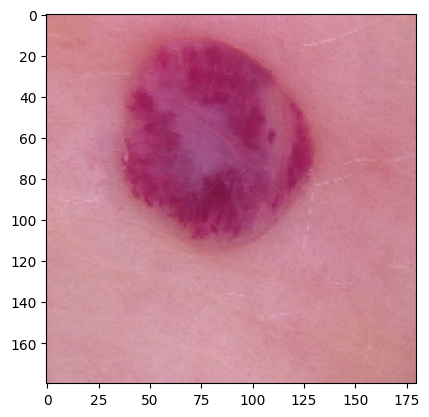

In [42]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[8], '*')
Test_image = glob(Test_image_path)
print(Test_image)
Test_image = load_img(Test_image[2],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[8] +'\n'+ "Predictive Class "+pred_class )